In [11]:
import torch
import torch.nn as nn
import numpy as np
from kan import *
from kan.utils import sparse_mask

class MultiBasisKANLayer(nn.Module):
    """
    KANLayer class with support for multiple basis function types between nodes
    """
    def __init__(self, in_dim=3, out_dim=2, num=5, k=3, cheb_degree=5, noise_scale=0.5, scale_base_mu=0.0, scale_base_sigma=1.0, scale_sp=1.0, base_fun=torch.nn.SiLU(), grid_eps=0.02, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, save_plot_data=True, device='cpu', sparse_init=False, basis_config=None):
        super(MultiBasisKANLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num = num
        self.k = k
        self.cheb_degree = cheb_degree
        self.grid_range = grid_range

        # Default to all splines if no basis_config provided
        if basis_config is None:
            self.basis_config = {(i, j): 'spline' for i in range(in_dim) for j in range(out_dim)}
        else:
            self.basis_config = basis_config

        # Initialize separate parameters for different basis types
        self.init_spline_params()
        self.init_chebyshev_params()

        # Scales and base function
        self.scale_base = nn.Parameter(
            scale_base_mu * 1 / np.sqrt(in_dim) +
            scale_base_sigma * (torch.rand(in_dim, out_dim)*2-1) * 1/np.sqrt(in_dim)
        )
        self.scale_sp = nn.Parameter(torch.ones(in_dim, out_dim) * scale_sp)
        self.base_fun = base_fun

        self.to(device)

    def init_spline_params(self):
        """Initialize parameters for spline connections"""
        self.spline_connections = {
            (i, j) for (i, j), basis in self.basis_config.items() if basis == 'spline'
        }
        if len(self.spline_connections) > 0:
            grid = torch.linspace(self.grid_range[0], self.grid_range[1], steps=self.num + 1)[None,:].expand(self.in_dim, self.num+1)
            grid = extend_grid(grid, k_extend=self.k)
            self.grid = nn.Parameter(grid, requires_grad=False)

            spline_coefs = torch.zeros(self.num+1, self.in_dim, self.out_dim)
            for i, j in self.spline_connections:
                spline_coefs[:, i, j] = torch.randn(self.num+1) * 0.1

            self.spline_coef = nn.Parameter(
                curve2coef(self.grid[:, self.k:-self.k].permute(1,0), spline_coefs, self.grid, self.k)
            )

    def init_chebyshev_params(self):
        """Initialize parameters for Chebyshev polynomial connections"""
        self.chebyshev_connections = {
            (i, j) for (i, j), basis in self.basis_config.items() if basis == 'chebyshev'
        }
        if len(self.chebyshev_connections) > 0:
            self.cheby_coeffs = nn.Parameter(torch.empty(self.in_dim, self.out_dim, self.cheb_degree + 1))
            nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (self.in_dim * (self.cheb_degree + 1)))

    def normalize_input(self, x):
        return torch.tanh(x)

    def evaluate_chebyshev(self, x):
        x = self.normalize_input(x)
        x = x.view((-1, self.in_dim, 1)).expand(-1, -1, self.cheb_degree + 1)
        x = x.acos()
        x *= torch.arange(0, self.cheb_degree + 1, device=x.device)
        x = x.cos()
        y = torch.einsum("bid,iod->bo", x, self.cheby_coeffs)
        return y

    def forward(self, x):
        batch = x.shape[0]
        preacts = x[:, None, :].clone().expand(batch, self.out_dim, self.in_dim)

        base = self.base_fun(x)

        y = torch.zeros(batch, self.in_dim, self.out_dim, device=x.device)

        if self.spline_connections:
            spline_output = coef2curve(x, self.grid, self.spline_coef, self.k)
            for i, j in self.spline_connections:
                y[:, i, j] = spline_output[:, i, j]

        if self.chebyshev_connections:
            cheb_output = self.evaluate_chebyshev(x)
            for i, j in self.chebyshev_connections:
                y[:, i, j] = cheb_output[:, j]

        y = self.scale_base[None, :, :] * base[:, :, None] + self.scale_sp[None, :, :] * y
        postacts = y.clone().permute(0, 2, 1)
        postspline = y.clone().permute(0, 2, 1)
        y = torch.sum(y, dim=1)
        return y, preacts, postacts, postspline

In [16]:
# Define the basis configuration
basis_config = {
    (0, 0): 'spline',
    (0, 1): 'chebyshev',
    (1, 0): 'chebyshev',
    (1, 1): 'spline'
}

# Create the layer
model = MultiBasisKANLayer(
    in_dim=2,
    out_dim=2,
    basis_config=basis_config,
    num=5,
    k=3,
    cheb_degree=5,
    grid_range=[-1, 1]
)

# Use the layer
x = torch.randn(100, 2)
y = torch.sin(x) + x
y, preacts, postacts, postspline = model(y)

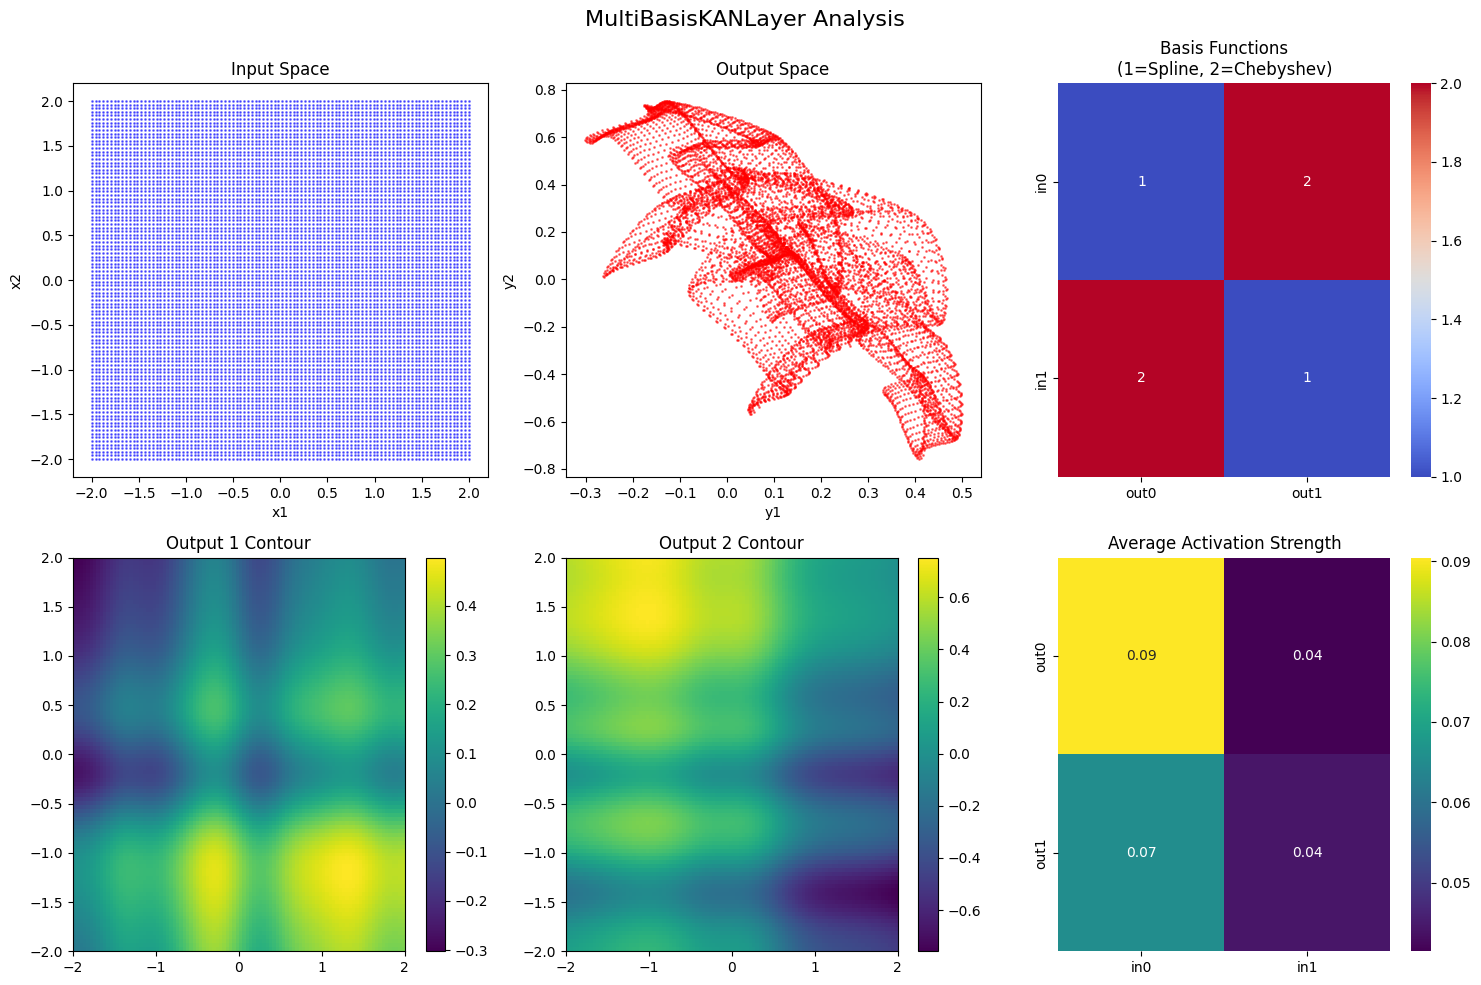

Epoch 0, Loss: 0.8238
Epoch 10, Loss: 0.3509
Epoch 20, Loss: 0.1617
Epoch 30, Loss: 0.0941
Epoch 40, Loss: 0.0539
Epoch 50, Loss: 0.0261
Epoch 60, Loss: 0.0157
Epoch 70, Loss: 0.0125
Epoch 80, Loss: 0.0122
Epoch 90, Loss: 0.0121


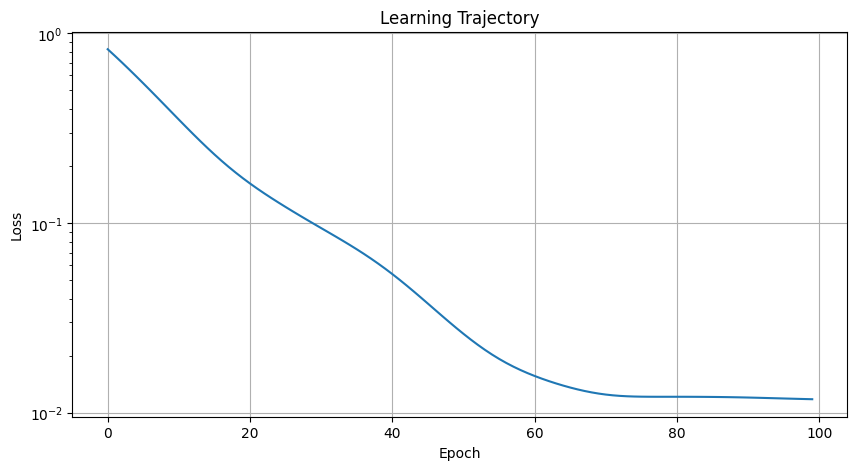

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_kan_layer(model, num_points=100):
    # Create a grid of input points
    x1 = np.linspace(-2, 2, num_points)
    x2 = np.linspace(-2, 2, num_points)
    X1, X2 = np.meshgrid(x1, x2)
    
    # Reshape for model input
    X = torch.tensor(np.column_stack((X1.ravel(), X2.ravel())), dtype=torch.float32)
    
    # Get model outputs
    y, preacts, postacts, postspline = model(X)
    Y = y.detach().numpy()
    
    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.suptitle('MultiBasisKANLayer Analysis', fontsize=16)
    
    # Plot input space
    axs[0,0].scatter(X[:,0], X[:,1], c='blue', alpha=0.5, s=1)
    axs[0,0].set_title('Input Space')
    axs[0,0].set_xlabel('x1')
    axs[0,0].set_ylabel('x2')
    
    # Plot output space
    axs[0,1].scatter(Y[:,0], Y[:,1], c='red', alpha=0.5, s=1)
    axs[0,1].set_title('Output Space')
    axs[0,1].set_xlabel('y1')
    axs[0,1].set_ylabel('y2')
    
    # Plot basis function types
    basis_matrix = np.zeros((model.in_dim, model.out_dim))
    for (i, j), basis_type in model.basis_config.items():
        basis_matrix[i,j] = 1 if basis_type == 'spline' else 2
    
    sns.heatmap(basis_matrix, annot=True, fmt='.0f', cmap='coolwarm',
                xticklabels=[f'out{i}' for i in range(model.out_dim)],
                yticklabels=[f'in{i}' for i in range(model.in_dim)],
                ax=axs[0,2])
    axs[0,2].set_title('Basis Functions\n(1=Spline, 2=Chebyshev)')
    
    # Plot individual output components
    Y1 = Y[:,0].reshape(num_points, num_points)
    Y2 = Y[:,1].reshape(num_points, num_points)
    
    im1 = axs[1,0].imshow(Y1, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
    axs[1,0].set_title('Output 1 Contour')
    plt.colorbar(im1, ax=axs[1,0])
    
    im2 = axs[1,1].imshow(Y2, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
    axs[1,1].set_title('Output 2 Contour')
    plt.colorbar(im2, ax=axs[1,1])
    
    # Plot activation patterns
    postacts_mean = postacts.mean(dim=0).detach().numpy()
    sns.heatmap(postacts_mean, annot=True, fmt='.2f', cmap='viridis',
                xticklabels=[f'in{i}' for i in range(model.in_dim)],
                yticklabels=[f'out{i}' for i in range(model.out_dim)],
                ax=axs[1,2])
    axs[1,2].set_title('Average Activation Strength')
    
    plt.tight_layout()
    plt.show()

# Create test data and visualize
visualize_kan_layer(model)

# Plot learning over time
def plot_learning_trajectory(model, num_epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Create some dummy training data
    X = torch.randn(1000, 2)
    Y_target = torch.sin(X[:,0]) + torch.cos(X[:,1])
    
    losses = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output, _, _, _ = model(X)
        loss = torch.nn.functional.mse_loss(output[:,0], Y_target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Learning Trajectory')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Visualize learning trajectory
plot_learning_trajectory(model)